# Camera Trap to Random Forests in Python

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from datetime import datetime as dt

### CSV

Bring in the CSV data. The data is also available in JSON, which may actually be the most intuitive and efficient structure to unpack from in the long run.  

In [1]:
import os
os.getcwd()
os.chdir("/Users/henrysun_1/Documents/GitHub/hbwater_cameratrap_pheno/scripts/sandbox/ML/data_raw")

'/Users/henrysun_1/Documents/GitHub/hbwater_cameratrap_pheno/scripts/sandbox/ML'

In [4]:
csv_df = pd.read_csv('example_data/hbwater_w3_bottom_1_1_20-3_5_20_csv.csv')


In [5]:
csv_df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,invert_Hbwtr_w3_20200101_120451.JPG,180286,"{""attribute"":{}}",20,0,"{""name"":""rect"",""x"":199,""y"":2028,""width"":46,""he...","{""attribute"":{""open_water_dark"":true}}"
1,invert_Hbwtr_w3_20200101_120451.JPG,180286,"{""attribute"":{}}",20,1,"{""name"":""rect"",""x"":192,""y"":2125,""width"":33,""he...","{""attribute"":{""open_water_dark"":true}}"
2,invert_Hbwtr_w3_20200101_120451.JPG,180286,"{""attribute"":{}}",20,2,"{""name"":""rect"",""x"":396,""y"":2022,""width"":38,""he...","{""attribute"":{""open_water_dark"":true}}"
3,invert_Hbwtr_w3_20200101_120451.JPG,180286,"{""attribute"":{}}",20,3,"{""name"":""rect"",""x"":488,""y"":2114,""width"":45,""he...","{""attribute"":{""open_water_dark"":true}}"
4,invert_Hbwtr_w3_20200101_120451.JPG,180286,"{""attribute"":{}}",20,4,"{""name"":""rect"",""x"":670,""y"":2079,""width"":43,""he...","{""attribute"":{""open_water_dark"":true}}"


<hr>

### Wrangle the Data

unpack 'region_attributes' column data to produce **class** variable

In [8]:
# image_class is a list- built to accept the
# modified 'region_attribute' data  
image_class = []

# created by the for loop below
for i in range(len(csv_df['region_attributes'])):
    
    # convert the strings of json data into python dictionaries
    json_item = json.loads(csv_df['region_attributes'][i])
    
    # if data is not empty dictionary
    if json_item:
        
        # extract the name of the key, as a string in a list
        image_type = list(json_item['attribute'].keys())
        
        # if dictionary entry is not empty list
        if image_type:
            image_type = image_type[0]

        # leave None for empty values
        else:
            image_type = None
    else:
        image_type = None
        
    # add value to image_class
    image_class.append(image_type)

# make image_class a column of our dataframe
csv_df['class'] = image_class

unpack 'region_shape' column data to produce **name** , **x** coordinate, **y** coordinate, **width** and **height** data

In [9]:
# unpack 'region_shape_attributes' into string of desired data
# leaving 'None' for empty values

# create dictionary to accept region shape data
region_shapes = {
    'name': [],
    'x': [],
    'y': [],
    'width': [],
    'height': [],
    }

# loop thru region attribute data
for i in range(len(csv_df['region_shape_attributes'])):
    # convert json strings to python dictionaries
    json_item = json.loads(csv_df['region_shape_attributes'][i])
    
    # loop thru the dictionary keys
    for attr in region_shapes.keys():
        # if JSON item contains data
        if json_item:
            # pull data item
            region_attr = json_item[attr]
            # append to that attribute's list in dictionary
            region_shapes[attr].append(region_attr)
        else:
            # otherwise, append None to appropriate list
            region_shapes[attr].append(None)
    
# create columns of this data in dataframe
for variable in region_shapes.keys():
    csv_df[variable] = region_shapes[variable]

extract data frome the file name to produce **system**, **watershed**, **date**, and **pic_id** data

In [10]:
# dictionary of filename data
filename_data = {
    'system': [],
    'watershed': [],
    'date': [],
    'pic_id': [],
}

# loop through filename string
for i in range(len(csv_df['filename'])):
    # split contents by underscore
    file_items = csv_df['filename'][i].split('_')

    # add system column for 'hbwtr'
    filename_data['system'].append(file_items[1])
    # add watershed olumn, 'w1', 'w2', etc.
    filename_data['watershed'].append(file_items[2])
    # add date column
    filename_data['date'].append(
                                # modify integer date to date format, MM/DD/YYYY
                                dt.strptime(file_items[3], '%Y%m%d').strftime('%m/%d/%Y')
                                )
    # add picture id number
    filename_data['pic_id'].append(file_items[4])

# create columns of this data in dataframe
for variable in filename_data.keys():
    csv_df[variable] = filename_data[variable]

adding calculated variables, for now, **area** and **aspect ratio**

In [11]:
# create polygon_area column
calculations = {
    'area': [],
    'aspect_ratio': []
}

# loop through dataframe
for i in range(len(csv_df['filename'])):
    # params
    height = csv_df['height'][i]
    width = csv_df['width'][i]
    
    # calcs
    area =  height * width
    aspect_ratio = height/width
    
    calculations['area'].append(area)
    calculations['aspect_ratio'].append(aspect_ratio)
    
# create columns of this data in dataframe
for variable in calculations.keys():
    csv_df[variable] = calculations[variable]

In [12]:
# make list to reorder columns
cols = csv_df.columns.tolist()
new_cols = cols[:1] + cols[13:16] + cols[7:13] + cols[16:17] + cols[1:7] + cols[17:]

csv_df = csv_df[new_cols]

step 2: extract pixel information from x,y,width, height 

In [13]:
import skimage
import skimage.io
from skimage.io import imread  # form 3, load only the imread function
import matplotlib.pyplot as plt
import skimage.draw
%matplotlib widget


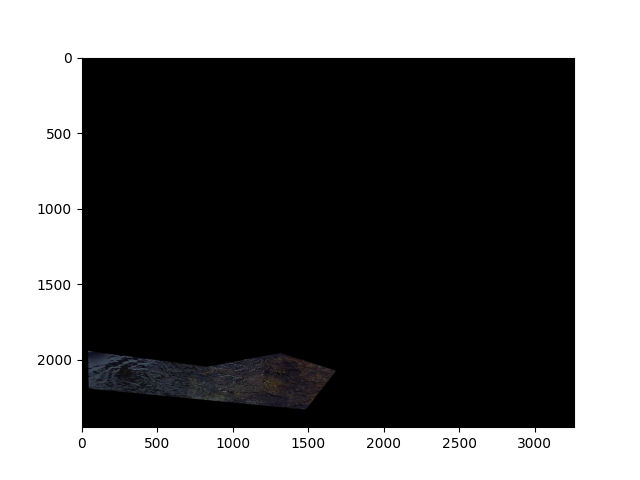

In [14]:
os.chdir("/Users/henrysun_1/Downloads/hbwtr_w3_bottom_1-1-20 thru 3-5-20")
image1 = skimage.io.imread(fname="invert_Hbwtr_w3_20200101_120451.jpg")
fig, ax = plt.subplots() 
plt.imshow(image1)

The following code help download and curate the dataframe before adding to MACHINE LEARNING

<div class="alert alert-info" role="alert">
  This dataframe now contains all original data, and many variables extracted or calculated from the original data contents. The rest of this notebook will manipulate this dataset further to feed it to a random forest model. Before this, the three cells directly below will contain commented code which will download three different versions of the CSV.
    <ol>
        <li> the full data, original and wrangled </li>
        <li> a slimmed dataset, containing all the original information, but with reducded redundancy</li>
        <li> a dataset removed of all categorical variables for easy use in the random forest model </li>
    </ol>
</div>

In [15]:
# 1: Download Full Dataframe
csv_df.to_csv('camera_data_raw.csv')

In [16]:
csv_df.head()

,filename,system,watershed,date,class,name,x,y,width,height,pic_id,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,area,aspect_ratio
0,invert_Hbwtr_w3_20200101_120451.JPG,Hbwtr,w3,01/01/2020,open_water_dark,rect,199,2028,46,41,120451.JPG,180286,"{""attribute"":{}}",20,0,"{""name"":""rect"",""x"":199,""y"":2028,""width"":46,""he...","{""attribute"":{""open_water_dark"":true}}",1886,0.891304
1,invert_Hbwtr_w3_20200101_120451.JPG,Hbwtr,w3,01/01/2020,open_water_dark,rect,192,2125,33,27,120451.JPG,180286,"{""attribute"":{}}",20,1,"{""name"":""rect"",""x"":192,""y"":2125,""width"":33,""he...","{""attribute"":{""open_water_dark"":true}}",891,0.818182
2,invert_Hbwtr_w3_20200101_120451.JPG,Hbwtr,w3,01/01/2020,open_water_dark,rect,396,2022,38,35,120451.JPG,180286,"{""attribute"":{}}",20,2,"{""name"":""rect"",""x"":396,""y"":2022,""width"":38,""he...","{""attribute"":{""open_water_dark"":true}}",1330,0.921053
3,invert_Hbwtr_w3_20200101_120451.JPG,Hbwtr,w3,01/01/2020,open_water_dark,rect,488,2114,45,35,120451.JPG,180286,"{""attribute"":{}}",20,3,"{""name"":""rect"",""x"":488,""y"":2114,""width"":45,""he...","{""attribute"":{""open_water_dark"":true}}",1575,0.777778
4,invert_Hbwtr_w3_20200101_120451.JPG,Hbwtr,w3,01/01/2020,open_water_dark,rect,670,2079,43,35,120451.JPG,180286,"{""attribute"":{}}",20,4,"{""name"":""rect"",""x"":670,""y"":2079,""width"":43,""he...","{""attribute"":{""open_water_dark"":true}}",1505,0.813953


In [17]:
# split pixels
import itertools
from PIL import Image
# save new data points to this list
li = []

for ind, row in csv_df.iterrows():
   y_range = (row.y, row.y+row.height)
   x_range = (row.x, row.x+row.width)
   # print(y_range, x_range)
   # calculate the coordinates range in the x and y axis
   range_list =  [range(row.x, row.x+row.width), range(row.y,row.y+row.height)]
   # set product of x_range and y_range
   combination_list = list(itertools.product(*range_list))
   width, height = 1,1
   for new_x, new_y in combination_list:       
      li.append([row["filename"],  new_x, new_y, width, height, row["class"]])
      
pixels_df = pd.DataFrame(li, columns=['filename', 'x', 'y', 'width', 'height', 'class'])
pixels_df.head()

,filename,x,y,width,height,class
0,invert_Hbwtr_w3_20200101_120451.JPG,199,2028,1,1,open_water_dark
1,invert_Hbwtr_w3_20200101_120451.JPG,199,2029,1,1,open_water_dark
2,invert_Hbwtr_w3_20200101_120451.JPG,199,2030,1,1,open_water_dark
3,invert_Hbwtr_w3_20200101_120451.JPG,199,2031,1,1,open_water_dark
4,invert_Hbwtr_w3_20200101_120451.JPG,199,2032,1,1,open_water_dark


In [18]:
# shape of new generated dataset
pixels_df.shape, csv_df.shape

((1102369, 6), (1506, 19))

In [19]:
# create image dictionary
image_dict = {}
def my_func(row):
    if row["filename"] in image_dict:
        return
    path =  "/Users/henrysun_1/Downloads/hbwtr_w3_bottom_1-1-20 thru 3-5-20/"+row["filename"]
    img= np.asarray(Image.open(path))
    image_dict[row["filename"]] = img

_ = csv_df.apply(lambda c: my_func(c),axis=1)

In [20]:
# Assign image pixel values for each row
def assign_pixels(row):
    return image_dict[row["filename"]][row.y:row.y+1, row.x:row.x+1].flatten()
pixels_df["RGB"] = pixels_df.apply(lambda row: assign_pixels(row),axis=1)

# create color channels
pixels_df["R"] = pixels_df.apply(lambda row: row["RGB"][0],axis=1)
pixels_df["G"] = pixels_df.apply(lambda row: row["RGB"][1],axis=1)
pixels_df["B"] = pixels_df.apply(lambda row: row["RGB"][2],axis=1)
pixels_df.head()

,filename,x,y,width,height,class,RGB,R,G,B
0,invert_Hbwtr_w3_20200101_120451.JPG,199,2028,1,1,open_water_dark,"[30, 32, 47]",30,32,47
1,invert_Hbwtr_w3_20200101_120451.JPG,199,2029,1,1,open_water_dark,"[20, 22, 37]",20,22,37
2,invert_Hbwtr_w3_20200101_120451.JPG,199,2030,1,1,open_water_dark,"[15, 17, 32]",15,17,32
3,invert_Hbwtr_w3_20200101_120451.JPG,199,2031,1,1,open_water_dark,"[16, 18, 33]",16,18,33
4,invert_Hbwtr_w3_20200101_120451.JPG,199,2032,1,1,open_water_dark,"[18, 21, 30]",18,21,30


In [21]:
# save data set
pixels_df.to_csv("pixels_df.csv")

<hr>

## Model

In [22]:
# Random Forest prep dataframe
# drop all categorical data (except class, for now)
df = pixels_df.drop(["filename", "width", "height"],axis=1)
df = df[["x","y","R","G","B", "class"]]

# drop all None values
df = df.fillna(value=np.nan)
df = df.dropna()
print(df.shape)

df.head()

(1100873, 6)


,x,y,R,G,B,class
0,199,2028,30,32,47,open_water_dark
1,199,2029,20,22,37,open_water_dark
2,199,2030,15,17,32,open_water_dark
3,199,2031,16,18,33,open_water_dark
4,199,2032,18,21,30,open_water_dark


In [23]:
# Train test split
from sklearn.model_selection import train_test_split
X = df.drop('class',axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [24]:
# fit model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [39]:
# predict on test data
rfc_pred = rfc.predict(X_test)

In [40]:
print(confusion_matrix(y_test,rfc_pred))

[[ 18943     81      4     10      1     13     10]
 [    74  37350   1170     60     11     39     21]
 [    14    654 171270   1915      6      0      2]
 [     0     36   4798  48714      6      0      0]
 [     0     24     11      2   3972      3      6]
 [    16     17      0      0      5  36325      1]
 [    41     57     16      1      5     18   4540]]


In [41]:
print(classification_report(y_test,rfc_pred))

                  precision    recall  f1-score   support

           ice_o       0.99      0.99      0.99     19062
           ice_t       0.98      0.96      0.97     38725
 open_water_dark       0.97      0.99      0.98    173861
open_water_green       0.96      0.91      0.93     53554
          riffle       0.99      0.99      0.99      4018
          snow_o       1.00      1.00      1.00     36364
          snow_t       0.99      0.97      0.98      4678

        accuracy                           0.97    330262
       macro avg       0.98      0.97      0.98    330262
    weighted avg       0.97      0.97      0.97    330262

